## Global Precipitation ##


This experiment aims to visualize the global influence of climate change regarding the annual precipitation.

Precipitation is one of the most important renweable water resources, influencing ground water as well as surface water. Agriculture also heavily relies on rainfall to water and grow a wide variety of crops. 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import matplotlib.patches as mpatches
import matplotlib
import sys
import os
import numpy as np
from tueplots.constants.color import rgb
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from tueplots import bundles

plt.rcParams.update(bundles.icml2022())
plt.rcParams.update({"figure.dpi": 200})

# colormap for Spatial Data
alpha = 1
rb = LinearSegmentedColormap.from_list(
    "rb", [(57/255, 38/255 , 19/255, alpha), (198/255, 140/255, 83/255, alpha), 
           [1, 1, 1, alpha], (0, 0.6, 1, alpha), (0, 0, 0.8, alpha)], N=500
)

#(0.4, 0.2 , 0, alpha)
#0.92, 0.86, 0.7

from netCDF4 import Dataset
import xarray as xr
import cartopy.crs as ccrs  # plotting library for geospatial data

sys.path.insert(1, os.path.abspath(os.getcwd()[:-3]))

### Import Timeseries Precipitation Data ###
----------------------------------------------------------
Source: Extended Version of NOAA - GPCC Dataset (2022)

Timespan: 1901 to 2021

Baseline: 1901 to 2000

Unit: Annual Precipitation Anomaly [mm]

----------------------------------------------------------
 
First we try to obtain an overview regarding the annual precipitation anomalies over time. By doing so we might observe important trends in the data.

precipitation_annualy_mean.csv already exists.


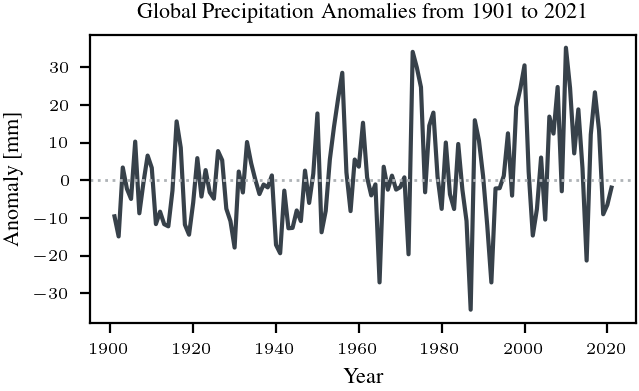

In [3]:
from src.utils import download_dataset
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

download_dataset(file_path='precipitation_annualy_mean.csv', 
                 url='https://www.epa.gov/system/files/other-files/2022-07/precipitation_fig-2.csv',
                 subfolder='climate_data')

# precipitation anomalies compared to 1901–2000 average
df = pd.read_csv(os.path.relpath('../dat/climate_data/precipitation_annualy_mean.csv'), sep = ',', skiprows=6)

# convert inches to milimeters
df['Anomaly'] = df['Anomaly '].multiply(25.4)


fig, ax = plt.subplots()

ax.set_ylabel("Anomaly [mm]")
ax.set_title("Global Precipitation Anomalies from 1901 to 2021")
ax = sns.lineplot(df, x = 'Year', y = 'Anomaly', color = rgb.tue_dark)
ax.axhline(y=0, linewidth=1, color=rgb.tue_gray, ls=':')


The visualization above is improved by adding a colormap and fitting a linear regression estimator.

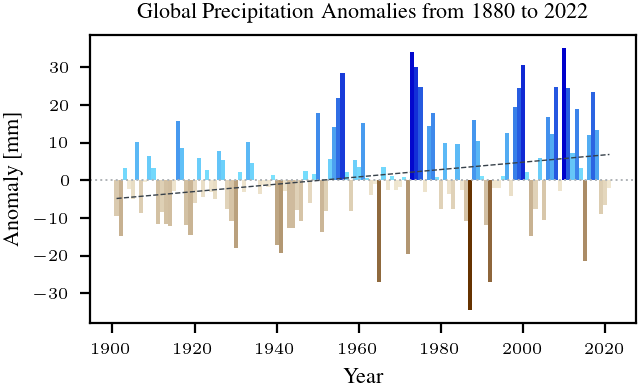

In [4]:
x = df['Year'].to_numpy()
y = df['Anomaly'].to_numpy()

fig, ax = plt.subplots()

# create colormap by stacking blue cm (for values larger than 0) and brown cm (for values smaller than zero)
colors_blue = [(0, 0.8, 1, 0.5), (0, 0, 0.8, 1)]  # Light Blue, Dark Blue
colors_brown = [(0.4, 0.2 , 0, 1), (0.92, 0.86, 0.7, 0.5)]   # Dark Brown, Light Brown


cm2 = LinearSegmentedColormap.from_list('cm2', colors_blue, N=256)
cm3 = LinearSegmentedColormap.from_list('cm3', colors_brown, N=256)

newcolors = np.vstack((cm3(np.linspace(0, 1, 128)),
                       cm2(np.linspace(0, 1, 128))))

warm_cold_cm = ListedColormap(newcolors, name='RedBlue')

# since colormap scales colors according to values between 0 and one, we want to 
# assign anomalies > 0 a value between 0.5 and 1, so its drawn orange / red and anomalies
# and assign anomalies <0 a value between 0 and 0.5 so its drawn blue
def rescale(y):
    result = np.zeros(y.shape)
    for i in range(0, y.shape[0]):
        elem = y[i]
        if elem >= 0:
            result[i] = elem / (2*np.max(y)) + 0.5
        else:
            result[i] = np.abs(elem) / (2*np.min(y)) + 0.5
    return result
    

# plot anomalies over years
ax.bar(x, y, color=warm_cold_cm(rescale(y)), width=1)
ax.axhline(y=0, linewidth=0.7, color=rgb.tue_gray, ls=':')
ax.set_xlabel("Year")
ax.set_ylabel("Anomaly [mm]")
ax.set_title("Global Precipitation Anomalies from 1880 to 2022")

#add regression line
b,a = np.polyfit(x, y, deg = 1)
xseq = np.linspace(np.min(x), np.max(x), num=100)
ax.plot(xseq, a + b * xseq, color=rgb.tue_dark, lw=0.5, ls='--')

Comparing this plot to the time series data of the temperature anomalies (exp_global_temperature.ipynb), one is not able to observe a clear trend similar to the steady temperature increase which would indicate more or less rainfall over time.

Since there is no average global trend visible, spatial precipitation data needs to be visualized in order to verify whether certain regions are impacted by decreasing rainfall and droughts that could heavily impact the freshwater availability.

### Import Spatial Precipitation Data ###
----------------------------------------------------------

Source: NOAA - CMAP Precipitation

Timespan: 1979/01 to 2023/12

Unit: Average monthly precipitation data [mm / day]

----------------------------------------------------------

To do so, we import a gridded precipitation dataset containing spatial information regarding the mean absolute precipitation per day

In [5]:
download_dataset(file_path='precip.mon.mean.nc', 
                 url='https://downloads.psl.noaa.gov//Datasets/cmap/enh/precip.mon.mean.nc',
                 subfolder='climate_data')

data = xr.open_dataset("../dat/climate_data/precip.mon.mean.nc")
df = data.to_dataframe()
df.head()

precip.mon.mean.nc already exists.


precip
lat   lon  time              
88.75 1.25 1979-01-01    0.21
           1979-02-01    0.30
           1979-03-01    0.15
           1979-04-01    0.22
           1979-05-01    0.30

First, the monthly datapoints from the dataset for the year 2022 are extracted and averaged, to obtain the average annual precipitation per year in [mm / day].

In [6]:
# average data over whole year 2022

# select data for each month of year 2022
dt64_start = np.datetime64('2022-01-01T00:00:00.000000000')
dt64_end = np.datetime64('2022-12-01T00:00:00.000000000')

filtered_data = data.sel(time=slice(dt64_start, dt64_end))
# dataframe now contains 12 months
filtered_data

<xarray.Dataset>
Dimensions:  (lat: 72, lon: 144, time: 12)
Coordinates:
  * lat      (lat) float32 88.75 86.25 83.75 81.25 ... -83.75 -86.25 -88.75
  * lon      (lon) float32 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * time     (time) datetime64[ns] 2022-01-01 2022-02-01 ... 2022-12-01
Data variables:
    precip   (time, lat, lon) float32 0.35 0.34 0.33 0.31 ... 0.18 0.18 0.17
Attributes:
    Conventions:    COARDS
    title:          CPC Merged Analysis of Precipitation (includes NCEP Reana...
    platform:       Analyses
    source:         ftp ftp.cpc.ncep.noaa.gov precip/cmap/monthly
    dataset_title:  CPC Merged Analysis of Precipitation
    documentation:  https://www.esrl.noaa.gov/psd/data/gridded/data.cmap.html
    date_modified:  26 Feb 2019
    References:     https://www.psl.noaa.gov/data/gridded/data.cmap.html
    version:        V2401
    history:        update 01/2024 V2401
    data_modified:  2024-01-08

In [7]:
# average over all 12 months
filtered_data = filtered_data.mean(dim = ("time"))
filtered_data

<xarray.Dataset>
Dimensions:  (lat: 72, lon: 144)
Coordinates:
  * lat      (lat) float32 88.75 86.25 83.75 81.25 ... -83.75 -86.25 -88.75
  * lon      (lon) float32 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
Data variables:
    precip   (lat, lon) float32 0.4742 0.4658 0.46 0.455 ... 43.37 45.0 47.02

Secondly, in order to compute the anomaly we extract the monthly data between 1979 - 2000 and compute the mean to use this as a baseline metric.

In [8]:
# do the same for the average reference frame (1979-2000)
# data for years <1979 not available
# select data for each month of timestpan 1979-2000
dt64_start = np.datetime64('1979-01-01T00:00:00.000000000')
dt64_end = np.datetime64('2000-12-01T00:00:00.000000000')

filtered_data_2 = data.sel(time=slice(dt64_start, dt64_end))
# dataframe now contains 12 months
filtered_data_2 = filtered_data_2.mean(dim = ("time"))

Now the anomaly can be calculated. The metric employed here is the annual precipitation anomaly in percent (\%). One could also use the absolute difference, however by normalizing w.r.t. the baseline average untypical precipitation rates for all regions are highlighted. In regions where the absolute precipitation is large, the absolute difference would often be also much larger compared to countries where the absolute precipitation is low.

$$
anomaly = 100 \cdot \frac{mean_{2022} - mean_{1979-2000}}{mean_{1979-2000}}
$$

In [9]:
# calculate precipitation anomaly [%] by 
# substracting baseline average (1979-2000) from values of year 2022 and dividing by baseline average
anomaly = 100 * (filtered_data - filtered_data_2) / filtered_data_2

With the obtained anomaly metric the spatial data (Precipitation Anomaly [\%]) for the year 2022 compared to the baseline average (1979-2000) can be visualized 

Text(0.5, 1.0, 'Precipitation Anomalies - Year 2022')

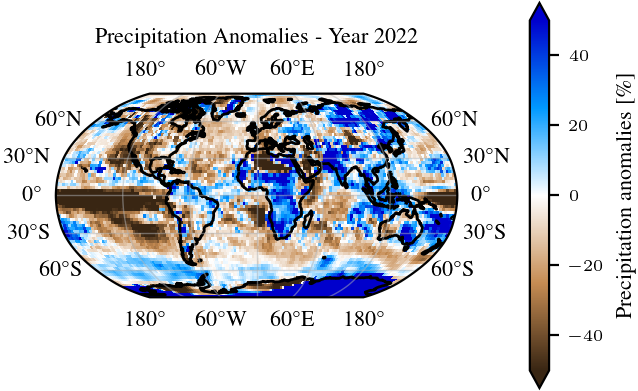

In [10]:
# Create a plot
plt.rcParams.update(bundles.icml2022())
fig = plt.figure()

ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())
#ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.coastlines()
plot = anomaly["precip"].plot(ax=ax, transform=ccrs.PlateCarree(), cmap=rb, vmin = -50, vmax = 50, add_colorbar=False)
# rename colorbar label
cb = plt.colorbar(mappable=plot, label = 'Precipitation anomalies [\%]', extend = 'both')

# add gridlines to globe
gl = ax.gridlines(
    crs=ccrs.PlateCarree(),
    draw_labels=True,
    linewidth=.5,
    color=rgb.tue_gray,
    alpha=0.5,
    linestyle="-",
)

gl.top_labels = True
gl.right_labels = True
ax.set_title("Precipitation Anomalies - Year 2022")

This figure shows that the precipitation did not decrease globally, there seem to be certain regions which are particularly impacted by less rainfall. Some of these countries already suffer under water scarcity issues (see exp_global_water_withdrawal_map.ipynb)

When extending the time horizon from one to five years to minimize the influence of short term precipitation anomalies, similar regions are impacted:

To do so, we calculate the mean precipitation for the timespan 2017 to 2022 and subsequently apply the anomaly metric described previously.

In [11]:
# average data over whole timespan 2017-2022
start_year = '2017'
end_year = '2022'

# select data for each month of year 2017-2022
dt64_start = np.datetime64(start_year + '-01-01T00:00:00.000000000')
dt64_end = np.datetime64(end_year + '-12-01T00:00:00.000000000')

filtered_data_3 = data.sel(time=slice(dt64_start, dt64_end))
filtered_data_3 = filtered_data_3.mean(dim = ("time"))

# calculate precipitation anomaly [%] 
anomaly_2 = 100 * (filtered_data_3 - filtered_data_2) / filtered_data_2

Text(0.5, 1.0, 'Mean Precipitation Anomalies: 2017 - 2022')

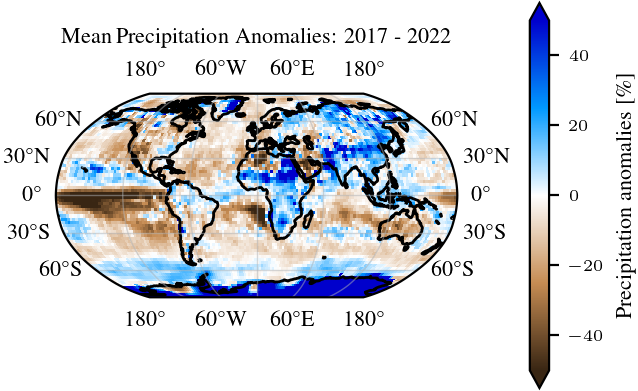

In [12]:
# Create a plot
plt.rcParams.update(bundles.icml2022())
fig = plt.figure()

ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())
#ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.coastlines()
plot = anomaly_2["precip"].plot(ax=ax, transform=ccrs.PlateCarree(), cmap=rb, vmin = -50, vmax = 50, add_colorbar=False)
# rename colorbar label
cb = plt.colorbar(mappable=plot, label = 'Precipitation anomalies [\%]', extend = 'both')

# add gridlines to globe
gl = ax.gridlines(
    crs=ccrs.PlateCarree(),
    draw_labels=True,
    linewidth=.5,
    color=rgb.tue_gray,
    alpha=0.5,
    linestyle="-",
)

gl.top_labels = True
gl.right_labels = True
ax.set_title("Mean Precipitation Anomalies: " + start_year + " - " + end_year)

Even when extending the time span to six years, it is clearly visible that some regions have had much less rainfall (up to rougly 50%) during the last five years compared to their respective baseline average. Thus it can be concluded that contrary to the temperature anomalies only some countries will have to deal with the issue of decreasing rainfall and droughts, since precipitation does not decrease globally but rather regionally. This decrease in precipitation can have a significat influence on the water stress levels of the impacted countries and measurements might be required. Other countries however can expect rising ground water levels due to an increase in precipitation.